# NFL Punt Analytics Competition
    -By Daniel Saltz and Jeff Saltz


# Introduction
There are endless possible rule changes that could make NFL punt plays safer. Very few, however, can be practically enforced without undermining the integrity of the game. In this kernel, we analyze punt data from 2016 and 2017, as well as data from the 1970s, to derive specific, and actionable rule changes that the NFL could implement to dramatically decrease concussions.


# Summary
Before delving into the analysis, we want to state our conclusions at the outset. Afterwards, we will show how we arrived at our findings. Our kernel can be summarized by following points:
* Returned punts are **8** times more likely to cause a concussion than non returned punts
* Only **44%** of punts are returned, but those returns account for **86%** of concussions during punt plays
* Therefore, in order to reduce concussions during punt plays, we have to minimize punt *returns*
* As we will show in our analysis, the quality of the punt coverage is a huge factor in determining the rate of punt returns
* Hence, substantially improving the punt coverage defense will reduce concussions

**These findings ultimately lead us to the following two rules changes:**
1. Fair catches should be incentivized with a 5 yard bonus (Add the rule under Rule 10, Section 2, Article 4)
2. All members of the punting team should be permitted to cross the line of scrimmage prior to the punt being kicked
   * To make this rule change, simply eliminate the "Ineligible Downfield Kick" penalty
   * This would revert back to the existing NFL rule before 1974, and would be similar to NCAA rules

How did we arrive at these findings? First, we tried to determine the key factors that lead to concussions during punt plays.


# 1. What is they driver for concussions on punt plays?

After extracting how each punt play ended, we were able to compare the rate of concussions for each type of punt play. The results were as follows:

In [1]:
## Importing packages
suppressPackageStartupMessages(library(tidyverse)) # metapackage with helpful functions
suppressPackageStartupMessages(library(gridExtra))

In [2]:
################################################################################################
#   Load punt data, concussion data, and determine the play outcomes and the penalties
################################################################################################

# Load data from CSVs
punts <- read.csv("data/play_information.csv")
concussion_data <- read.csv("data/video_review.csv")

# Merge punt plays and concussion data
punts <- merge(x = punts, y = concussion_data, by=c("Season_Year","GameKey","PlayID"), all = TRUE)
punts$withConcussion <- !is.na(punts$GSISID)

# Temporarily remove any tricky plays - determining the distances on these are difficult]
removeWithKeyword <- function(keyword, ignore_case){
  return(punts[aregexec(keyword,punts$PlayDescription,max.distance=0, ignore.case=ignore_case) < 0,]) 
}

# Manually save the 3 punts that resulted in concussions during "MUFFS" or "No Play" plays
hard_coded_punt_outcomes1 <- list(538,29,"Returned",51,-16,89,73)
hard_coded_punt_outcomes2 <- list(1976,231,"Returned",58,13,73,86)
hard_coded_punt_outcomes3 <- list(3312,399,"Returned",36,3,44,47)
hard_coded_punts1 <- punts[punts$PlayID==538 & punts$GameKey==29,]
hard_coded_punts2 <- punts[punts$PlayID==1976 & punts$GameKey==231,]
hard_coded_punts3 <- punts[punts$PlayID==3312 & punts$GameKey==399,]

# Remove the tricky plays
punts <- removeWithKeyword("- No Play.",FALSE);
punts <- removeWithKeyword("MUFFS",TRUE);
punts <- removeWithKeyword("FUMBLES",TRUE);
punts <- removeWithKeyword("BLOCKED",TRUE);
punts <- removeWithKeyword("CHALLENGED",TRUE);
punts <- removeWithKeyword("got a hand on the punt",TRUE);

getPuntYards <- function(playDesc){
  regex <- regexpr("punts \\d{1,3} yards? to", playDesc, perl=FALSE)
  matched <- regmatches(playDesc, regex);
  punt_yards = as.integer(regmatches(matched, regexpr("\\d{1,3}",matched,perl=TRUE)))
  return (punt_yards);
}

getFairCatchAlternative <- function(play){
  playDesc <- play$PlayDescription
  punting_team <- play$Poss_Team
  regex_to_50 <- regexpr("punts \\d{1,3} yards? to 50", playDesc, perl=FALSE)
  if (regex_to_50[1] > 0){
    fair_catch_alternative = 50;
  } else {
    regex <- regexpr("punts \\d{1,3} yards? to [A-Z]{2,3} \\d{1,3}", playDesc, perl=FALSE)
    if (regex[1] < 0){ "to end zone"
      fair_catch_alternative = NA;
    }
    else {
      matched <- regmatches(playDesc, regex);
      regex <- regexpr("to [A-Z]{2,3} \\d{1,3}", playDesc, perl=FALSE)
      matched <- regmatches(playDesc, regex);
      field = regmatches(matched, regexpr("[A-Z]{2,3}",matched,perl=TRUE))
      yard_line = as.integer(regmatches(matched, regexpr("\\d{1,3}",matched,perl=TRUE)))
      fair_catch_alternative = scaleTo100(field,yard_line,punting_team)
    }
  }
  return (fair_catch_alternative);
}

scaleTo100 <- function(field, yard_line, punting_team){
  return (if (field == punting_team) yard_line else (100 - yard_line))
}

getReturnYards <- function(play, fair_catch_alternative, penalty){
  playDesc <- as.character(play$PlayDescription)
  punting_team <- as.character(play$Poss_Team)
  regex <- regexpr("for -?\\d{1,3} yards?", playDesc, perl=TRUE)
  if (regex[1] < 0){ # "touchback", "downed by", "out of bounds", or a return "for no gain"
    return_yards = 0;
  } else {
    matched <- regmatches(playDesc, regex);
    return_yards = as.integer(regmatches(matched, regexpr("-?\\d{1,3}",matched,perl=TRUE)))
    
    if (penalty$Has_Penalty){
      penalized_team <- penalty$Penalized_Team
      penaltyDesc <- penalty$Penalty_Desc
      regex <- regexpr("\\d{1,3} yards?, enforced at", penaltyDesc, perl=FALSE)
      matched <- regmatches(penaltyDesc, regex);
      penalty_yards <- as.integer(regmatches(matched, regexpr("\\d{1,3}",matched,perl=TRUE)))
      enforced_at <- getEnforcedAtYardLine(penaltyDesc,punting_team)
      
      if (penalized_team == punting_team){
        return_yards = return_yards + penalty_yards
      } else {
        return_starting_field_position = enforced_at + penalty_yards
        return_yards = fair_catch_alternative - return_starting_field_position
      }
    }
  }
  return (return_yards);
}

getEnforcedAtYardLine <- function(penaltyDesc, punting_team){
  if (aregexec("enforced at 50",penaltyDesc,max.distance=0, ignore.case=TRUE) > 0){
    enforced_at = 50
  } else {
    enforced_at_regex = regexpr("[A-Z]{2,3} \\d{1,3}", penaltyDesc, perl=FALSE)
    matched <- regmatches(penaltyDesc, enforced_at_regex);
    enforced_at_field = regmatches(matched, regexpr("[A-Z]{2,3}",matched,perl=TRUE))
    enforced_at_yard_line = as.integer(regmatches(matched, regexpr("\\d{1,3}",matched,perl=TRUE)))
    enforced_at = scaleTo100(enforced_at_field,enforced_at_yard_line,punting_team)
  }
  return (enforced_at)
}

getReturnOutcome <- function(play){
  possible_outcomes <- c("fair catch","out of bounds","downed by","Touchback")
  for (outcome in possible_outcomes){
    if (aregexec(outcome,play,max.distance=0, ignore.case=FALSE) > 0){
      return (outcome);
    }
  }
  if (regexpr("punts \\d{1,3} yards? to", play, perl=FALSE) < 0){
    return ("Not Punted");
  } else {
    return ("Returned");
  }
}

getReturningTeam <- function(play){
  punting_team <- as.character(play$Poss_Team)
  teams <- as.list(strsplit(as.character(play$Home_Team_Visit_Team), "-"))[[1]]
  return (if (punting_team == teams[1]) teams[2] else teams[1])
}

getPenalty <- function(play){
  playDesc <- as.character(play$PlayDescription)
  punting_team <- as.character(play$Poss_Team)
  returning_team <- getReturningTeam(play)
  playID = play$PlayID
  gameKey = play$GameKey
  has_penalty = FALSE
  penalty <- list(playID,gameKey,punting_team,returning_team,has_penalty,NA,NA,NA,NA,NA)
  penalties <- as.list(strsplit(playDesc, '(?i)Penalty on '))[[1]]
  
  if (length(penalties) > 1){
    for (i in 2:length(penalties)){
      penaltyDesc <- trimws(penalties[i])
      if (aregexec("offsetting",penaltyDesc,max.distance=0, ignore.case=TRUE) < 0
          & aregexec("declined",penaltyDesc,max.distance=0, ignore.case=TRUE) < 0
          & aregexec("enforced between downs",penaltyDesc,max.distance=0, ignore.case=TRUE) < 0){
        
        has_penalty = TRUE
        penalized_team <- regmatches(penaltyDesc, regexpr("[A-Z]{2,3}",penaltyDesc,perl=FALSE))
        penalty_yards <- getPenaltyYards(penaltyDesc)
        enforced_at <- getEnforcedAtYardLine(penaltyDesc,punting_team)
        penalty_type = getPenaltyType(penaltyDesc)
        penalty <- list(playID,gameKey,punting_team,returning_team,has_penalty,penaltyDesc,penalized_team,penalty_yards,penalty_type,enforced_at)
      }
    }
  }
  return (penalty);
}

getPenaltyType <- function(penaltyDesc){
  comma_list <- as.list(strsplit(penaltyDesc, ','))[[1]]
  penalty_type <- trimws(comma_list[2])
  return (penalty_type)
}

getPenaltyYards <- function(penaltyDesc){
  regex <- regexpr("\\d{1,3} yards?, enforced at", penaltyDesc, perl=FALSE)
  matched <- regmatches(penaltyDesc, regex);
  penalty_yards <- as.integer(regmatches(matched, regexpr("\\d{1,3}",matched,perl=TRUE)))
  return (penalty_yards)
}

punt_outcomes <- data.frame(matrix(ncol = 7, nrow = nrow(punts)))
colnames(punt_outcomes) <- c("PlayID", "GameKey", "Outcome", "Punt_Yards", "Return_Yards",
                             "Return_Yards_To_Go", "Fair_Catch_Yards_To_Go")

penalty_table <- data.frame(matrix(ncol = 10, nrow = nrow(punts)))
colnames(penalty_table) <- c("PlayID", "GameKey", "Punting_Team", "Returning_Team", "Has_Penalty",
                             "Penalty_Desc", "Penalized_Team", "Penalty_Yards",
                             "Penalty_Type", "Enforced_At_Yards_To_Go")

for (i in 1:nrow(punts)){
  playID = punts$PlayID[i];
  gameKey = punts$GameKey[i];
  playDesc = as.character(punts$PlayDescription[i]);
  outcome = getReturnOutcome(playDesc);
  
  if (outcome != "Not Punted"){
    play <- punts[i,]
    punt_yards = getPuntYards(playDesc);
    penalty_table[i,] <- getPenalty(play)
    
    fair_catch_alternative = getFairCatchAlternative(play);
    return_yards = getReturnYards(play,fair_catch_alternative,penalty_table[i,]);
    return_starting_field = fair_catch_alternative - return_yards;
    punt_outcomes[i,] <- list(playID,gameKey,outcome,punt_yards,return_yards,return_starting_field,fair_catch_alternative)
  } 
  else {
    punt_outcomes[i,] <- list(playID,gameKey,outcome,NA,NA,NA,NA)
    penalty_table[i,] <- list(playID,gameKey,NA,NA,NA,NA,NA,NA,NA,NA)
  }
}

# Add back the 3 manual punt returns that we saved at the beginning
punt_outcomes[i+1,] <- hard_coded_punt_outcomes1
punt_outcomes[i+2,] <- hard_coded_punt_outcomes2
punt_outcomes[i+3,] <- hard_coded_punt_outcomes3
punts[i+1,] <- hard_coded_punts1
punts[i+2,] <- hard_coded_punts2
punts[i+3,] <- hard_coded_punts3
penalty_table[i+1,] <- list(punts[i+1,]$PlayID,punts[i+1,]$GameKey,"NYJ","WAS",FALSE,NA,NA,NA,NA,NA)
penalty_table[i+2,] <- list(punts[i+2,]$PlayID,punts[i+2,]$GameKey,"CIN","BLT",FALSE,NA,NA,NA,NA,NA)
penalty_table[i+3,] <- list(punts[i+3,]$PlayID,punts[i+3,]$GameKey,"KC","NE",FALSE,NA,NA,NA,NA,NA)

# Merge punt plays data with punt outcomes and penalty outcomes
punts <- merge(x = punts, y = punt_outcomes, by=c("GameKey","PlayID"), all = TRUE)
punts <- merge(x = punts, y = penalty_table, by=c("GameKey","PlayID"), all = TRUE)

# Purge plays that were not punted
punts <- punts[punts$Outcome != "Not Punted",]          

# Create play_result field for convenience
punts$play_result <- punts$Outcome

In [3]:
# Get the likelihood of a concussion for each outcome of a punt play
touchback = sum(punts$play_result=="Touchback")
out_of_bounds = sum(punts$play_result=="out of bounds")
downed_by = sum(punts$play_result=="downed by")
fair_catch = sum(punts$play_result=="fair catch")
returned = sum(punts$play_result=="Returned")
total = touchback+out_of_bounds+downed_by+fair_catch+returned
non_returned = total - returned
          
touchback_conc = sum(punts$play_result == "touchback" & !is.na(punts$GSISID))
out_of_bounds_conc = sum(punts$play_result=="out of bounds" & !is.na(punts$GSISID))
downed_by_conc = sum(punts$play_result=="downed by" & !is.na(punts$GSISID))
fair_catch_conc = sum(punts$play_result=="fair catch" & !is.na(punts$GSISID))
returned_conc = sum(punts$play_result=="Returned" & !is.na(punts$GSISID))
total_conc = touchback_conc+out_of_bounds_conc+downed_by_conc+fair_catch_conc+returned_conc
non_returned_conc = total_conc - returned_conc

cat("% of Concussions during 'touchbacks': ", round(100*touchback_conc/touchback,3))
cat("\n% of Concussions during 'out of bounds': ", round(100*out_of_bounds_conc/out_of_bounds,3))
cat("\n% of Concussions during 'downed by': ", round(100*downed_by_conc/downed_by,3))
cat("\n% of Concussions during 'fair catch': ", round(100*fair_catch_conc/fair_catch,3))
cat("\n% of Concussions during 'returned': ", round(100*returned_conc/returned,3))
cat("\n% of Concussions during non returned plays: ", round(100*non_returned_conc/non_returned,3))
cat(paste0("\nReturns are ", round((returned_conc/returned)/(non_returned_conc/non_returned),3), " times more likely to cause concussions than non returns"))

% of Concussions during 'touchbacks':  0
% of Concussions during 'out of bounds':  0
% of Concussions during 'downed by':  0.384
% of Concussions during 'fair catch':  0.123
% of Concussions during 'returned':  1.171
% of Concussions during non returned plays:  0.146
Returns are 8.034 times more likely to cause concussions than non returns

Punt returns are **8** times more likely to cause concussions than non returns. That is a drastic difference that should be heavily analyzed.

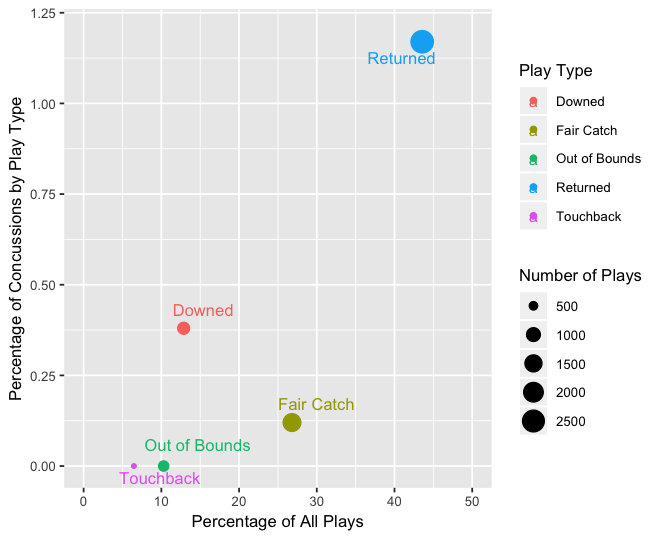

In [4]:
totalConc <- c(touchback_conc, out_of_bounds_conc, downed_by_conc, fair_catch_conc, returned_conc)
totals <- c(touchback, out_of_bounds, downed_by, fair_catch, returned)
totalConc <- c(touchback_conc, out_of_bounds_conc, downed_by_conc, fair_catch_conc, returned_conc)
type <- c("touchback", "out_of_bounds", "downed_by", "fair_catch", "returned")

percentOfConc <- round(100*totalConc/sum(totalConc), 2)
noConc <- totals - totalConc
numPlays <- c(totalConc, noConc)

percentConc <- c( 
  if (touchback_conc == 0) 0.00000 else round(100*touchback_conc/touchback,2),
  if (out_of_bounds_conc == 0) 0.00000 else round(100*out_of_bounds_conc/out_of_bounds,2),
  if (downed_by_conc == 0) 0.00000 else round(100*downed_by_conc/downed_by,2),
  if (fair_catch_conc == 0) 0.00000 else round(100*fair_catch_conc/fair_catch,2),
  if (returned_conc == 0) 0.00000 else round(100*returned_conc/returned,2)
)

percentPlay <- c( 
  round(100*touchback/total,2), 
  round(100*out_of_bounds/total,2),
  round(100*downed_by/total,2), 
  round(100*fair_catch/total,2), 
  round(100*returned/total,2)
)
      
percentPlays <- c(percentConc/sum(percentConc), percentPlay/sum(percentPlay))
percentOfConc <- round(100*totalConc/sum(totalConc), 2)
Punt_Plays <- c("Touchback", "Out of Bounds", "Downed", "Fair Catch", "Returned")
dfSummary <- data.frame(totals, totalConc, Punt_Plays, percentPlay, percentConc, percentOfConc)
dfSummary$NumberOfPlays <- dfSummary$totals
    
hjustV <- c(0.18, 0.18, 0.18, 0.18, 0.8)
vjustV <- c(1.5, -1.3, -1.1, -1.1, 1.8)
options(repr.plot.width=5.5, repr.plot.height=4.5)
ggplot(dfSummary, aes(y = percentConc, x = percentPlay, group=Punt_Plays,color=Punt_Plays, size = NumberOfPlays)) + 
  geom_point() + geom_text(size=3.5, aes(label=Punt_Plays),hjust=hjustV, vjust=vjustV) + theme(text = element_text(size=10)) +
  labs(y="Percentage of Concussions by Play Type", x="Percentage of All Plays",
      color="Play Type", size="Number of Plays") +
  ylim(0, 1.2) + xlim(0,50)

In addition, punt returns account for **44%** of punt plays, but cause **86%** of punt-related concussions. 

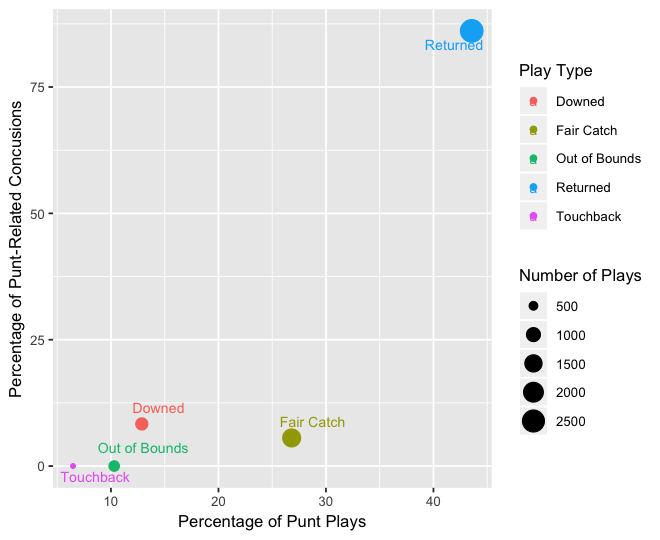

In [5]:
percentOfConc <- round(100*totalConc/sum(totalConc), 2)
Punt_Plays <- c("Touchback", "Out of Bounds", "Downed", "Fair Catch", "Returned")
dfSummary <- data.frame(totals, totalConc, Punt_Plays, percentPlay, percentConc, percentOfConc)
dfSummary$NumberOfPlays <- dfSummary$totals
hjustV <- c(0.18, 0.18, 0.18, 0.18, 0.8)
vjustV <- c(1.5, -1.3, -1.1, -1.1, 1.8)
options(repr.plot.width=5.5, repr.plot.height=4.5)
ggplot(dfSummary, aes(y = percentOfConc, x = percentPlay, group=Punt_Plays,color=Punt_Plays, size = NumberOfPlays)) + 
  geom_point() + geom_text(size=3, aes(label=Punt_Plays),hjust=hjustV, vjust=vjustV) +
  labs(y="Percentage of Punt-Related Concusions", x="Percentage of Punt Plays",
  size="Number of Plays", color="Play Type") + theme(text = element_text(size=10))

These two statistics combined tell us that punt returns are extremely dangerous, especially compared to all other punt plays. 

 ### **This means that in order to decrease concussions, punt returns should be minimized.**



# 2. What is the best way to minimize punt returns?

We are only considering rule changes that wouldn't undermine the integrity of the game. For example, simply abolishing punt returns altogether is not an actionable rule suggestion. Would teams be forced to go for it on every 4th down? This type of rule suggestion would overhaul the integrity.
 
However, what if teams *chose* to go for it more on 4th down, rather than punting? What if teams *chose* to bypass punt returns more frequently? The question becomes, what type of incentive or situation would lead teams to make those decisions?  There's a few ways to do this. We can either make punt returns so difficult that teams are no longer gaining positive yardage, or we can make the alternatives to punt returns more attractive. We will address both of these strategies.

The alternatives to returning a punt are letting the ball bounce and be downed by the punting team, letting the ball go out of bounds, attempting to let the ball roll for a touchback, and making a fair catch. We want to change the incentives such that returners will choose non return options. Punts that are headed out of bounds aren't able to be returned. Punts that result in touchbacks are seldom returned, as a touchback is usually a better outcome than a punt return. Fair catches on the other hand, are primed for a rule change. Even with only a few yards of separation between the punt returner and the oncoming defenders, returners aren't incentivized to make a fair catch. But changing the rules could tilt the incentives in favor of a fair catch. We propose instituting a 5 yard bonus for every fair catch. After this rule change, a punt returner knows that he should only return the punt if he can gain more than 5 yards. Otherwise, he risks losing yardage relative to the free 5 yard fair catch bonus, plus he takes on the additional risk of fumbling the football. **The effect of a 5 yard fair catch bonus would be significant, as 45% of punt returns go for under 5 net yards (after factoring in penalties).** 

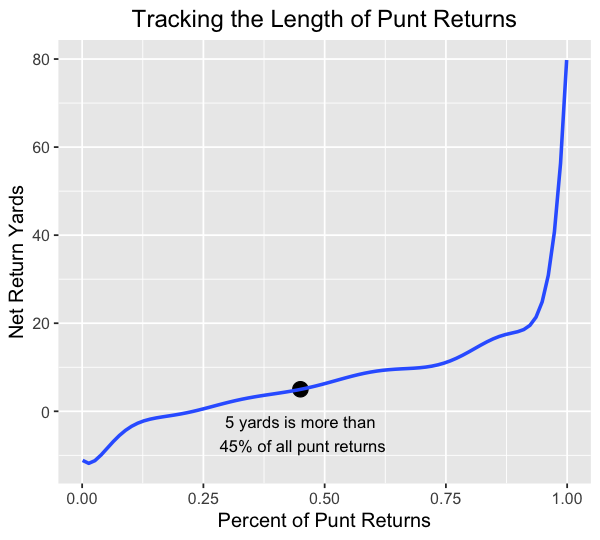

In [6]:
tmpPunts <- punts[punts$play_result == "Returned",]
percentReturnedAbove <- c(replicate(50, 0))
percentYards <- c(replicate(50, 0))

for (i in 1:50){
  percentReturnedAbove[i] <- nrow(tmpPunts[tmpPunts$Return_Yards > i*2,])/nrow(tmpPunts) * 100
  percentYards[i] <- i*2
}

dfTmp <- data.frame(percentYards, percentYards)

percentOfReturns <- c(1:999)/1000
returnYards <- quantile(tmpPunts$Return_Yards, percentOfReturns)
dfTmp <- data.frame(returnYards, percentOfReturns)

returnYardsV <- 5
percentBetterThan <- round(100-nrow(tmpPunts[tmpPunts$Return_Yards > returnYardsV,])/nrow(tmpPunts) * 100)
percentValues <- 0.45
pointLabels <- "5 yards is more than\n 45% of all punt returns"
dfTmp1 <- data.frame(returnYardsV, percentValues, pointLabels)

options(repr.plot.width=5, repr.plot.height=4.5)
ggplot(dfTmp1, aes(y=returnYardsV, x=percentValues)) + 
  geom_text(data=dfTmp1, size=3.5, aes(label=pointLabels),vjust=1.75)  + 
  geom_point(data= dfTmp1, y=returnYardsV, x = percentValues, size=4) + 
  stat_smooth(data=dfTmp, aes(x = percentOfReturns , y = returnYards), method = "lm",
              formula = y ~ poly(x, 10), se = FALSE) +
  ylab("Net Return Yards") + xlab("Percent of Punt Returns") + theme(text = element_text(size=12)) +
  ggtitle("Tracking the Length of Punt Returns") + theme(plot.title = element_text(hjust = 0.5))

In addition to making fair catches more desirable than punt returns, we want to make punt returns more difficult so that returners think twice before bypassing the fair catch bonus. To do this, we looked at the player role data in order to gain insights from punt formations. Did certain punt coverages lead to more concussions than others? 

There appears to be a reduction in concussions from havings single coverage on gunners rather than double coverage. This makes sense, becuase single covered gunners are able to get downfield quicker, forcing punt returners into making fair catches more often. When a gunner is double covered, the punt returner has more time to return the punt. The increased rate of punt returns is what causes the large majority of punt-related concussions.

Therefore, one possible rule change would be to mandate single coverage on gunners. That seems simple enough, except there are a few factors that make this rule change suggestion less than ideal. First, it is not entirely clear how to prohibit double coverage on gunners. You can prohibit two defenders from standing across a gunner at the line of scrimmage, but what if one defender stays at the line of scrimmage while another waits 20 yards downfield? Enforcing such a rule would be difficult and would require additional rule changes for the rule to be enforceable. Second of all, simply comparing single vs double coverage might be misleading. Single coverage could be an indication that the punt return team is trying to set up a punt block. In other words, single vs. double coverage does not indicate whether the return team is setting up a return or a punt block. And finally, single vs. double coverage on gunners does not solve the main problem. As shown in the chart below, the vast majority of punt returns already occur with single coverage on a gunner. Therefore, we need more drastic measures in order to improve punt coverage well enough to deter a larger percentage of punt returns. 

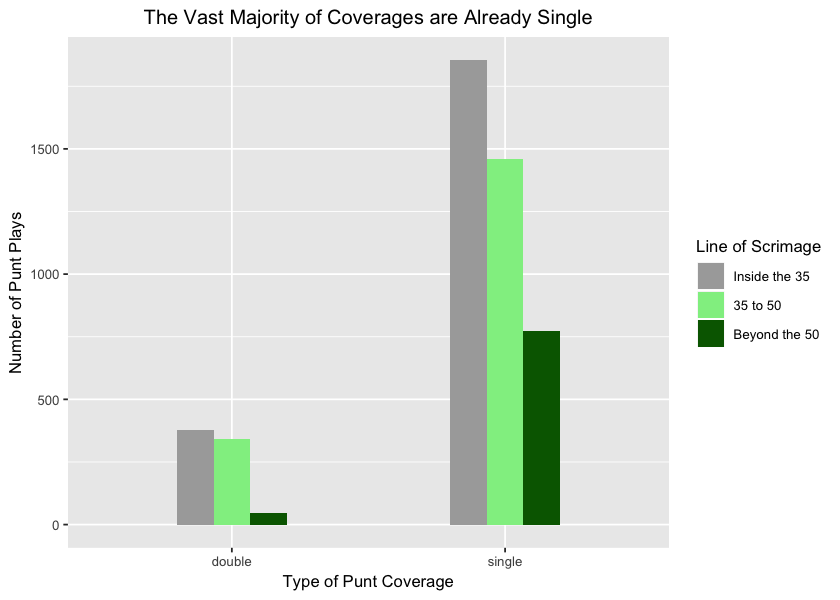

In [7]:

playerRole_data <- read.csv("data/play_player_role_data.csv")

role.vr <- playerRole_data[playerRole_data$Role == 'VR', ]
role.vr$singleLeftGunner <- TRUE
role.vr$Role <- NULL

role.vl <- playerRole_data[playerRole_data$Role == 'VL', ]
role.vl$singleRightGunner <- TRUE
role.vl$Role <- NULL

punts1 <- merge(x = punts, y = role.vl, by=c("Season_Year","GameKey","PlayID"), all.x = TRUE)
punts2 <- merge(x = punts1, y = role.vr, by=c("Season_Year","GameKey","PlayID"), all = TRUE)
punts2 <- punts2[!is.na(punts2$withConcussion),]

####################
#plays with single, double or bybrid coverage
##################
punts2$singleCoverage <- !is.na(punts2$singleLeftGunner) & !is.na(punts2$singleRightGunner)
punts2$doubleCoverage <- is.na(punts2$singleLeftGunner) & is.na(punts2$singleRightGunner)
punts2$hybridCoverage <- (!punts2$singleCoverage & !punts2$doubleCoverage)

punts2$coverageType <- "Hybrid"
punts2$coverageType[punts2$doubleCoverage == TRUE] <- "Double"
punts2$coverageType[punts2$singleCoverage == TRUE] <- "Single"

punts <- punts2

###########
#get punting yard line position#
###########
punts$YardLine <- as.character(punts$YardLine)
team <- trimws(substring(punts$YardLine, 1, 3))
tmp <- trimws(substring(punts$YardLine, 4))
punts$puntingPosition <- as.integer(tmp)

punts$amountToAdd <- 50 - punts$puntingPosition
punts$amountToAdd [team == punts$Punting_Team] <- 0
punts$puntingPosition <- punts$puntingPosition + punts$amountToAdd*2
punts$amountToAdd <- NULL

#look at punts that are "full distance"
punts.long <- punts[punts$puntingPosition < 35,]

punts.long.single <- punts.long[punts.long$singleCoverage == TRUE,]
punts.long.double <- punts.long[punts.long$doubleCoverage == TRUE,]

#see concussions on both
p1 <- sum(punts.long.single$withConcussion)/nrow(punts.long.single)*100
p2 <- sum(punts.long.double$withConcussion)/nrow(punts.long.double)*100

#cat("Percent of plays with concussions, punting 'normal/long' inside the team's 30 yard line, single coverage", p1, "\n")
#cat("Percent of plays with concussions, punting 'normal/long' inside the team's 30 yard line, double coverage", p2,"\n")

punts.middle <- punts[punts$puntingPosition < 51,]
punts.middle <- punts.middle[punts.middle$puntingPosition > 34,]
punts.middle.single <- punts.middle[punts.middle$singleCoverage == TRUE,]
punts.middle.double <- punts.middle[punts.middle$doubleCoverage == TRUE,]

#look at punts that are not "full distance"
punts.short <- punts[punts$puntingPosition > 50,]

punts.short.single <- punts.short[punts.short$singleCoverage == TRUE,]
punts.short.double <- punts.short[punts.short$doubleCoverage == TRUE,]

#see concussions on both
p1 <- sum(punts.short.single$withConcussion)/nrow(punts.short.single)*100
p2 <- sum(punts.short.double$withConcussion)/nrow(punts.short.double)*100

#cat("Percent of plays with concussions, punting 'shorter punts' outside the team's 40 yard line, single coverage", p1, "\n")
#cat("Percent of plays with concussions, punting 'shorter punts' outside the team's 40 yard line, double coverage", p2, "\n")

punts.full <- punts

getPercentOfPlays <- function(punts) {
  touchback = sum(punts$play_result=="Touchback")
  out_of_bounds = sum(punts$play_result=="out of bounds")
  downed_by = sum(punts$play_result=="downed by")
  fair_catch = sum(punts$play_result=="fair catch")
  returned = sum(punts$play_result=="Returned")
  total = touchback+out_of_bounds+downed_by+fair_catch+returned
  v <- c(0,0,0,0,0,0)
  
  v[1] <- round(touchback/total*100,2)
  v[2] <- round(out_of_bounds/total*100,2)
  v[3] <- round(downed_by/total*100,2)
  v[4] <- round(fair_catch/total*100,2)
  v[5] <- round(returned/total*100,2)
  v[6] <- 100
  
  return( v )
}

getPercentConc <- function(punts) {
  touchback = sum(punts$play_result=="Touchback")
  out_of_bounds = sum(punts$play_result=="out of bounds")
  downed_by = sum(punts$play_result=="downed by")
  fair_catch = sum(punts$play_result=="fair catch")
  returned = sum(punts$play_result=="Returned")
  total = touchback+out_of_bounds+downed_by+fair_catch+returned
  
  touchback_conc = sum(punts$play_result == "touchback" & punts$withConcussion)
  out_of_bounds_conc = sum(punts$play_result=="out of bounds" & punts$withConcussion)
  downed_by_conc = sum(punts$play_result=="downed by" & punts$withConcussion)
  fair_catch_conc = sum(punts$play_result=="fair catch" & punts$withConcussion)
  returned_conc = sum(punts$play_result=="Returned" & punts$withConcussion)
  total_conc = touchback_conc+out_of_bounds_conc+downed_by_conc+fair_catch_conc+returned_conc
  
  v <- c(0,0,0,0,0,0)
  
  if (touchback_conc == 0) v[1] <- 0 else v[1] <- round(touchback_conc/touchback*100,2)
  if (out_of_bounds_conc == 0) v[2] <- 0 else v[2] <- round(out_of_bounds_conc/out_of_bounds*100,2)
  if (downed_by_conc == 0) v[3] <- 0 else v[3] <- round(downed_by_conc/downed_by*100,2)
  if (fair_catch_conc == 0) v[4] <- 0 else v[4] <- round(fair_catch_conc/fair_catch*100,2)
  if (returned_conc == 0) v[5] <- 0 else v[5] <- round(returned_conc/returned*100,2)
  if (total_conc == 0) v[6] else v[6] <- round(total_conc/total*100,2)
  
  return( v )
}

getConc <- function(punts) {
  touchback_conc = sum(punts$play_result == "touchback" & punts$withConcussion)
  out_of_bounds_conc = sum(punts$play_result=="out of bounds" & punts$withConcussion)
  downed_by_conc = sum(punts$play_result=="downed by" & punts$withConcussion)
  fair_catch_conc = sum(punts$play_result=="fair catch" & punts$withConcussion)
  returned_conc = sum(punts$play_result=="Returned" & punts$withConcussion)
  total_conc = touchback_conc+out_of_bounds_conc+downed_by_conc+fair_catch_conc+returned_conc
  v1 <- c(touchback_conc, out_of_bounds_conc, downed_by_conc, fair_catch_conc, returned_conc, total_conc)
  return( v1 )
}

conc.short.double <- getPercentOfPlays(punts.short.double)
conc.short.single <- getPercentOfPlays(punts.short.single)
conc.middle.double <- getPercentOfPlays(punts.middle.double)
conc.middle.single <- getPercentOfPlays(punts.middle.single)

conc.long.double <- getPercentOfPlays(punts.long.double)
conc.long.single <- getPercentOfPlays(punts.long.single)
typeOfPlays1 <- c("Touchback", "Out of Bounds", "Downed", "Fair Catch", "Returned", "All (Overall)")
dfPercent <- data.frame(conc.long.double, conc.middle.double, conc.short.double, conc.short.single, conc.middle.single, conc.long.single, typeOfPlays1)

conc.short.double <- getPercentConc(punts.short.double)
conc.short.single <- getPercentConc(punts.short.single)
conc.middle.double <- getPercentConc(punts.middle.double)
conc.middle.single <- getPercentConc(punts.middle.single)

conc.long.double <- getPercentConc(punts.long.double)
conc.long.single <- getPercentConc(punts.long.single)
typeOfPlays1 <- c("Touchback", "Out of Bounds", "Downed", "Fair Catch", "Returned", "All (Overall)")
dfConcPercent <- data.frame(conc.long.double, conc.middle.double, conc.short.double, conc.short.single, conc.middle.single, conc.long.single, typeOfPlays1)

conc.short.double <- getConc(punts.short.double)
conc.short.single <- getConc(punts.short.single)
conc.middle.double <- getConc(punts.middle.double)
conc.middle.single <- getConc(punts.middle.single)
conc.long.double <- getConc(punts.long.double)
conc.long.single <- getConc(punts.long.single)
typeOfPlays1 <- c("Touchback", "Out of Bounds", "Downed", "Fair Catch", "Returned", "All (Overall)")
dfConc <- data.frame(conc.long.double, conc.middle.double, conc.short.double, conc.short.single, conc.middle.single, conc.long.single, typeOfPlays1)

t <- paste0("percent long: ", round(nrow(punts.long)/nrow(punts)*100, 2), 
    "  percent middle: ", round(nrow(punts.middle)/nrow(punts)*100, 2), 
    "  percent short: ",  round(nrow(punts.short)/nrow(punts)*100, 2), "\n")

percent <- c(dfPercent$conc.long.double[1:5], dfPercent$conc.middle.double[1:5],dfPercent$conc.short.double[1:5],
             dfPercent$conc.long.single[1:5], dfPercent$conc.middle.single[1:5],dfPercent$conc.short.single[1:5])
typeOfKick <- c(replicate(5, "long"), replicate(5, "middle"),replicate(5, "short"),
                replicate(5, "long"), replicate(5, "middle"),replicate(5, "short"))
puntPlays <- c("Touchback", "Out of Bounds", "Downed", "Fair Catch", "Returned")
typeOfPlays <- c(puntPlays, puntPlays)
typeOfPlay <- c(typeOfPlays, typeOfPlays, typeOfPlays)

dfPercent1 <- data.frame(percent, typeOfKick, typeOfPlay)
#ggplot(dfPercent1, aes(x=typeOfPlay, y=percent, fill=typeOfKick)) + 
#  geom_col(position="dodge", width=0.4) +
#  scale_fill_manual(values=c("darkgrey","lightgreen", "darkgreen")) +  
#  ylab("Percentage of Punts") + xlab("Type of Punt Play") + theme(text = element_text(size=20))
#+ ggtitle("Expected Impact of New Rules on Types of Punt Returns")  

singleDf <- punts[punts$singleCoverage==TRUE,]
doubleDf <- punts[punts$doubleCoverage==TRUE,]

singleDf.short <- singleDf[singleDf$puntingPosition > 50,]
singleDf.long <- singleDf[singleDf$puntingPosition > 34,]
singleDf.middle <- singleDf[singleDf$puntingPosition < 51,]
singleDf.middle <- singleDf[singleDf.middle$puntingPosition > 34,]

doubleDf.short <- doubleDf[doubleDf$puntingPosition > 50,]
doubleDf.long <- doubleDf[doubleDf$puntingPosition > 34,]
doubleDf.middle <- doubleDf[doubleDf$puntingPosition < 51,]
doubleDf.middle <- doubleDf[doubleDf.middle$puntingPosition > 34,]

coveragePercent <- c(nrow(doubleDf.long), nrow(doubleDf.middle), nrow(doubleDf.short),
                     nrow(singleDf.long), nrow(singleDf.middle), nrow(singleDf.short))

typeOfCoverage <- c(replicate(3, "double"), replicate(3, "single")) 

typeOfKick <- c("short", "middle", "long", "short", "middle", "long") 
typeOfKick <- c("Inside the 35", "35 to 50", "Beyond the 50", "Inside the 35", "35 to 50", "Beyond the 50")
typeOfKick <- factor(typeOfKick, levels = c("Inside the 35", "35 to 50", "Beyond the 50"))

dfPercent2 <- data.frame(coveragePercent, typeOfKick,  typeOfCoverage)

options(repr.plot.width=7, repr.plot.height=5)
ggplot(dfPercent2, aes(x=typeOfCoverage, y=coveragePercent, fill=typeOfKick)) + 
  geom_col(position="dodge", width=0.4) +
  scale_fill_manual(values=c("darkgrey","lightgreen", "darkgreen")) +  
  labs(fill="Line of Scrimage") + 
  labs(y="Number of Punt Plays",x="Type of Punt Coverage",
      title="The Vast Majority of Coverages are Already Single") +
  theme(text = element_text(size=10), plot.title = element_text(hjust = 0.5))


Up until 1973, the NFL did not have a problem of having too many punt returns. In fact, they had they opposite problem. The rules were different back then. Today, only the 2 gunners are allowed to cross the line of scrimmage before the ball is punted. Back then, every member of the punting team was eligible to run downfield to cover the punt as soon as the ball was snapped. The punt covererage was so good, and punt returns were so difficult, that in 1974 the NFL changed these rules in order to increase punt return opportuniites and add excitement. Analyzing punt return data from 1971-1976 (3 years before and after the rule change), we can see a huge jump in the number of punts that were returned and the average yards gained per return. 

In [8]:
# Reference for historical punt returns: https://www.pro-football-reference.com/years/1975/returns.htm
returns_1971 <- read.csv("data/1971_Returns.csv")
returns_1972 <- read.csv("data/1972_Returns.csv")
returns_1973 <- read.csv("data/1973_Returns.csv")
returns_1974 <- read.csv("data/1974_Returns.csv")
returns_1975 <- read.csv("data/1975_Returns.csv")
returns_1976 <- read.csv("data/1976_Returns.csv")

# Clean up 70's punt return data
returns_1971 <- returns_1971[!is.na(returns_1971$Ret),]
returns_1972 <- returns_1972[!is.na(returns_1972$Ret),]
returns_1973 <- returns_1973[!is.na(returns_1973$Ret),]
returns_1974 <- returns_1974[!is.na(returns_1974$Ret),]
returns_1975 <- returns_1975[!is.na(returns_1975$Ret),]
returns_1976 <- returns_1976[!is.na(returns_1976$Ret),]

# Get average return from the 70's
attempts_1971 <- sum(returns_1971$Ret)
attempts_1972 <- sum(returns_1972$Ret)
attempts_1973 <- sum(returns_1973$Ret)
attempts_1974 <- sum(returns_1974$Ret)
attempts_1975 <- sum(returns_1975$Ret)
attempts_1976 <- sum(returns_1976$Ret)

return_yards_1971 <- sum(returns_1971$Yds)
return_yards_1972 <- sum(returns_1972$Yds)
return_yards_1973 <- sum(returns_1973$Yds)
return_yards_1974 <- sum(returns_1974$Yds)
return_yards_1975 <- sum(returns_1975$Yds)
return_yards_1976 <- sum(returns_1976$Yds)

ave_return_1971 <- round(return_yards_1971/attempts_1971,2)
ave_return_1972 <- round(return_yards_1972/attempts_1972,2)
ave_return_1973 <- round(return_yards_1973/attempts_1973,2)
ave_return_1974 <- round(return_yards_1974/attempts_1974,2)
ave_return_1975 <- round(return_yards_1975/attempts_1975,2)
ave_return_1976 <- round(return_yards_1976/attempts_1976,2)

# Years before rule changes vs. 3 years after
attempts_three_yrs_before <- attempts_1971 + attempts_1972 + attempts_1973
attempts_three_yrs_after <- attempts_1974 + attempts_1975 + attempts_1976
yards_three_yrs_before <- return_yards_1971 + return_yards_1972 + return_yards_1973
yards_three_yrs_after <- return_yards_1974 + return_yards_1975 + return_yards_1976
ave_three_yrs_before <- yards_three_yrs_before/attempts_three_yrs_before
ave_three_yrs_after <- yards_three_yrs_after/attempts_three_yrs_after
cat("Ave returns/year from 1971-1973: ", round(attempts_three_yrs_before/3))
cat("\nAve returns/year from 1974-1976: ", round(attempts_three_yrs_after/3))
cat("\nAve punt return from 1971-1973: ", round(ave_three_yrs_before,2))
cat("\nAve punt return from 1974-1976: ", round(ave_three_yrs_after,2))

# Percent increase in number of returns and ave return
percent_inc_in_returns <- 1- round(attempts_three_yrs_before/attempts_three_yrs_after,5)
percent_inc_in_ave_return <- 1- round(ave_three_yrs_before/ave_three_yrs_after,5)
cat("\nPercent increase in the number of returns/year: ", percent_inc_in_returns)
cat("\nPercent increase in average return yards: ", percent_inc_in_ave_return)

Ave returns/year from 1971-1973:  831
Ave returns/year from 1974-1976:  1191
Ave punt return from 1971-1973:  7.44
Ave punt return from 1974-1976:  9.32
Percent increase in the number of returns/year:  0.30199
Percent increase in average return yards:  0.20122

Average punt return yardage increased by **20%** (roughly 2 yards), and the number of punt returns per year increased by **30%**.  Allowing all players on the coverage team to defend the punt return will have a much more significant impact than mandating single coverage on gunners. Additionally, we know that such a rule change is very much "in the spirit of the game", since it was an NFL rule until 1974 and still is a rule in college football. 



# 3. How many fewer punt returns will there be?


We've discussed a few different factors that would lead to a decrease in the number of punt returns. The first is the 5 yard fair catch bonus. As previously mentioned, 45% of punt returns go for less than 5 yards. This 45% reduction could be spread out in any number of ways, but we believe in the following logic:
* Fair catches will increase becuase receiving teams will want the 5 yard fair catch bonus
* Punts out of bounds will increase because punting teams will want to avoid fair catches, especially near the goal line where they won't lose much yardage on a "coffin corner" punt
* Downed punts will increase if punters react to the rule change and try to "squib" the ball in an attempt to avoid a fair catch
* Touchbacks will largely remain the same
* Teams will go for it more on 4th down, since it will be harder to pin the returning team deep in their own territory

The punt formation change (rule change 2) will both decrease the average yards earned per punt return, and it will also reduce the overall number of punt returns. When the NFL initially changed the punt formation rules in 1974, average punt returns increased by 20% (2 yards), and the overall number of punt returns decreased by 30%. Given the huge advancement in punt coverage, both of these statistics make intuitive sense. We will use them as guidelines for what would happen if the the 1974 rule is reversed and our rule change is accepted.

Combining the two rules together:
* We estimate that the average punt return from 2016-2017 would have to go for more than 7 yards for it to be returned (5 yards from the fair catch bonus, plus 2 yards from the enhanced punt coverage)
* **55%** of punt returns from 2016 and 2017 went for less than 7 yards, and that is the percent decrease in punt returns that we will use in our analysis.

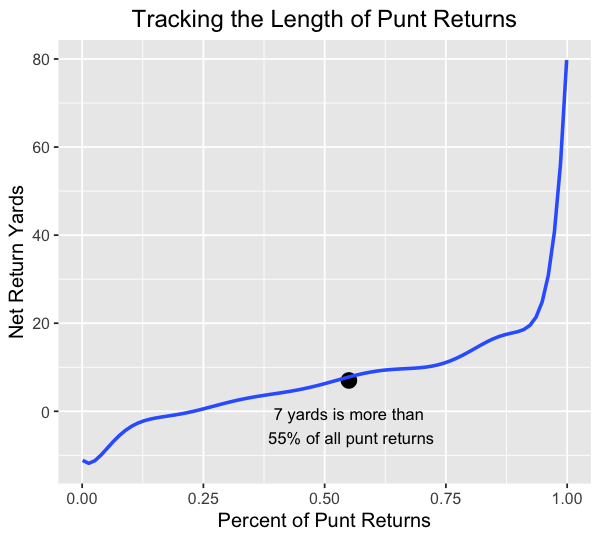

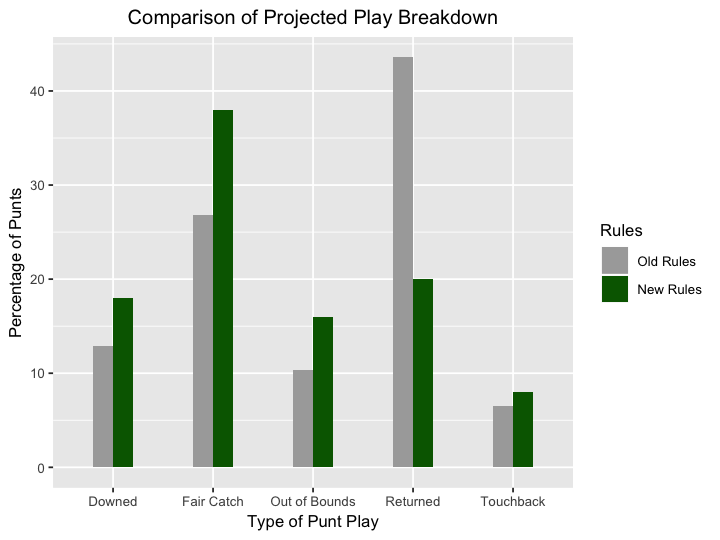

In [9]:
tmpPunts <- punts[punts$play_result == "Returned",]
percentReturnedAbove <- c(replicate(50, 0))
percentYards <- c(replicate(50, 0))

for (i in 1:50){
  percentReturnedAbove[i] <- nrow(tmpPunts[tmpPunts$Return_Yards > i*2,])/nrow(tmpPunts) * 100
  percentYards[i] <- i*2
}

dfTmp <- data.frame(percentYards, percentYards)

percentOfReturns <- c(1:999)/1000
returnYards <- quantile(tmpPunts$Return_Yards, percentOfReturns)
dfTmp <- data.frame(returnYards, percentOfReturns)

returnYardsV <- 7
percentBetterThan <- round(100-nrow(tmpPunts[tmpPunts$Return_Yards > returnYardsV,])/nrow(tmpPunts) * 100)
percentValues <- 0.55
pointLabels <- "7 yards is more than\n 55% of all punt returns"
dfTmp1 <- data.frame(returnYardsV, percentValues, pointLabels)

options(repr.plot.width=5, repr.plot.height=4.5)
ggplot(dfTmp1, aes(y=returnYardsV, x=percentValues)) + 
  geom_text(data=dfTmp1, size=3.5, aes(label=pointLabels),vjust=1.75)  + 
  geom_point(data= dfTmp1, y=returnYardsV, x = percentValues, size=4) + 
  stat_smooth(data=dfTmp, aes(x = percentOfReturns , y = returnYards), method = "lm",
              formula = y ~ poly(x, 10), se = FALSE) +
  ylab("Net Return Yards") + xlab("Percent of Punt Returns") + theme(text = element_text(size=12)) +
  ggtitle("Tracking the Length of Punt Returns") + theme(plot.title = element_text(hjust = 0.5))

# Draw chart showing new breakdown of each type of punt play
#55% scenario
newPercentPlay.touchback <- 8
newPercentPlay.out_of_bounds <- 16
newPercentPlay.downed_by <- 18
newPercentPlay.fair_catch <- 100-20-18-16-8
newPercentPlay.returned <- 20

newPercentPlay <- c(
  newPercentPlay.touchback,
  newPercentPlay.out_of_bounds,
  newPercentPlay.downed_by,
  newPercentPlay.fair_catch,
  newPercentPlay.returned)

percentOfPlays <- c(percentPlay, newPercentPlay)
rules <- c(replicate(5, "Old Rules"), replicate(5, "New Rules"))
rules <- factor(rules, levels = c("Old Rules", "New Rules"))
dfTmp <- data.frame(typeOfPlays, percentOfPlays, rules)

options(repr.plot.width=6, repr.plot.height=4.5)
ggplot(dfTmp, aes(x=typeOfPlays, y=percentOfPlays, fill=rules)) + 
  geom_col(position="dodge", width=0.4) +
  scale_fill_manual(values=c("darkgrey","darkgreen")) +  
  theme(text = element_text(size=10),plot.title = element_text(hjust = 0.5)) +
  labs(y="Percentage of Punts", x="Type of Punt Play", fill="Rules",
      title="Comparison of Projected Play Breakdown")


# 4. Net Impact on Concussions

Our method for calculating the net impact on concussions is as follows: First, we calculated the proportion of concussions that each type of punt play caused during the 2016 and 2017 seasons (divided into "Touchback", "Downed", "Out of Bounds", "Fair Catch", and “Returned”). Holding these proportions constant, we applied the 55% decrease in punt returns (and the corresponding redistribution towards other punt outcomes), to determine the projected number of concussions that would occur under the suggested rule changes.

### This leads to a projected decrease in concussions by **41%**. 

Play Type,Plays,% Concussions,Old Rules,New Rules
<fct>,<int>,<dbl>,<dbl>,<dbl>
Touchback,393,0.00,6.47,8
Out of Bounds,626,0.00,10.30,16
Downed,782,0.38,12.87,18
Fair Catch,1629,0.12,26.81,38
Returned,2647,1.17,43.56,20


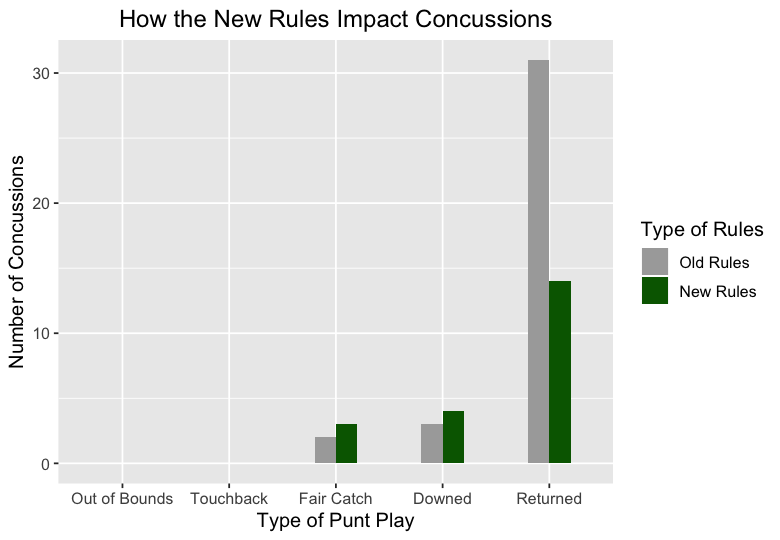

In [10]:
#predicting number of concussions - based on the new rules
getNewConcussionsWithNewRules <- function(newPercentPlay){
  return (round(sum(totals) * newPercentPlay/100 * dfSummary$percentConc/100, 0))
}

#create barchart comparing the concussions with new/old rule
genBarchartComparingConcussionsWithNewRules <- function(numConcussionsWithNewRules, titleText) {
  numConcussionsMerged <- c(totalConc, numConcussionsWithNewRules)
  playType  <- c(Punt_Plays, Punt_Plays)
  rules <- c(replicate(5, "Old Rules"), replicate(5, "New Rules"))
  rules <- factor(rules, levels = c("Old Rules", "New Rules"))
  
  dfSummary2 <- data.frame(numConcussionsMerged,playType, rules)
  dfSummary2 <- dfSummary2[order(-dfSummary2$numConcussionsMerged),]
  dfSummary2$playType <- reorder(dfSummary2$playType, dfSummary2$numConcussionsMerged)
    
  options(repr.plot.width=6.5, repr.plot.height=4.5)
  ggplot(dfSummary2, aes(x=playType, y=numConcussionsMerged, fill=rules)) + geom_col(position="dodge", width=0.4) + 
    labs(y="Number of Concussions", x="Type of Punt Play", fill="Type of Rules",title=titleText) +
    scale_fill_manual(values=c("darkgrey", "darkgreen")) +
    theme(text = element_text(size=12), plot.title = element_text(hjust = 0.5))
} 

getPercentDifferenceInConcussions <- function(concussionsDF){
    concussionsBefore <- concussionsDF$Plays * concussionsDF["% Concussions"]/100
    newRatioOfPlays <- sum(concussionsDF$Plays) * (concussionsDF["New Rules"]/100)
    concussionsAfter <-  newRatioOfPlays * concussionsDF["% Concussions"]/100
    concBefore <- sum(concussionsBefore)
    concAfter <- sum(concussionsAfter)
    percentDecreased <- round(100*(concBefore-concAfter)/concBefore)
    return (percentDecreased)
}

#55% scenario
newPercentPlay.touchback <- 8
newPercentPlay.out_of_bounds <- 16
newPercentPlay.downed_by <- 18
newPercentPlay.fair_catch <- 100-20-18-16-8
newPercentPlay.returned <- 20

newPercentPlay <- c(
  newPercentPlay.touchback,
  newPercentPlay.out_of_bounds,
  newPercentPlay.downed_by,
  newPercentPlay.fair_catch,
  newPercentPlay.returned)

concussionsDF <- setNames(data.frame(matrix(ncol = 5, nrow = 5)),
    c("Play Type","Plays", "% Concussions","Old Rules","New Rules"))

concussionsDF["Play Type"] <- dfSummary$Punt_Plays
concussionsDF["Plays"] <- totals
concussionsDF["% Concussions"] <- dfSummary$percentConc
concussionsDF["Old Rules"] <- dfSummary$percentPlay
concussionsDF["New Rules"] <- newPercentPlay
concussionsDF

reducedConcussionsBy <- getPercentDifferenceInConcussions(concussionsDF)

# Reduced concussions by 26%
numConcussionsWithNewRules <- getNewConcussionsWithNewRules(newPercentPlay)

title <- "How the New Rules Impact Concussions"
genBarchartComparingConcussionsWithNewRules(numConcussionsWithNewRules, title)

It's possible that NFL coaches would react slowly to the fair catch bonus. If that were the case, punt returns wouldn't decrease as drastically as we expect right after the rule change. Instead, it may take a couple of years for coaches and returners to grasp the new incentives of bypassing a return for the safety of the 5 yard bonus. Even if that were the case, it's very likely that punt returns would decrease *some* amount. And since punt returns are much more dangerous than all other punt plays, it doesn't take much of a decrease in punt returns to yield a big decrease in concussions. For example, with a 35% decrease in punt returns, concussions are still reduced by 26%.

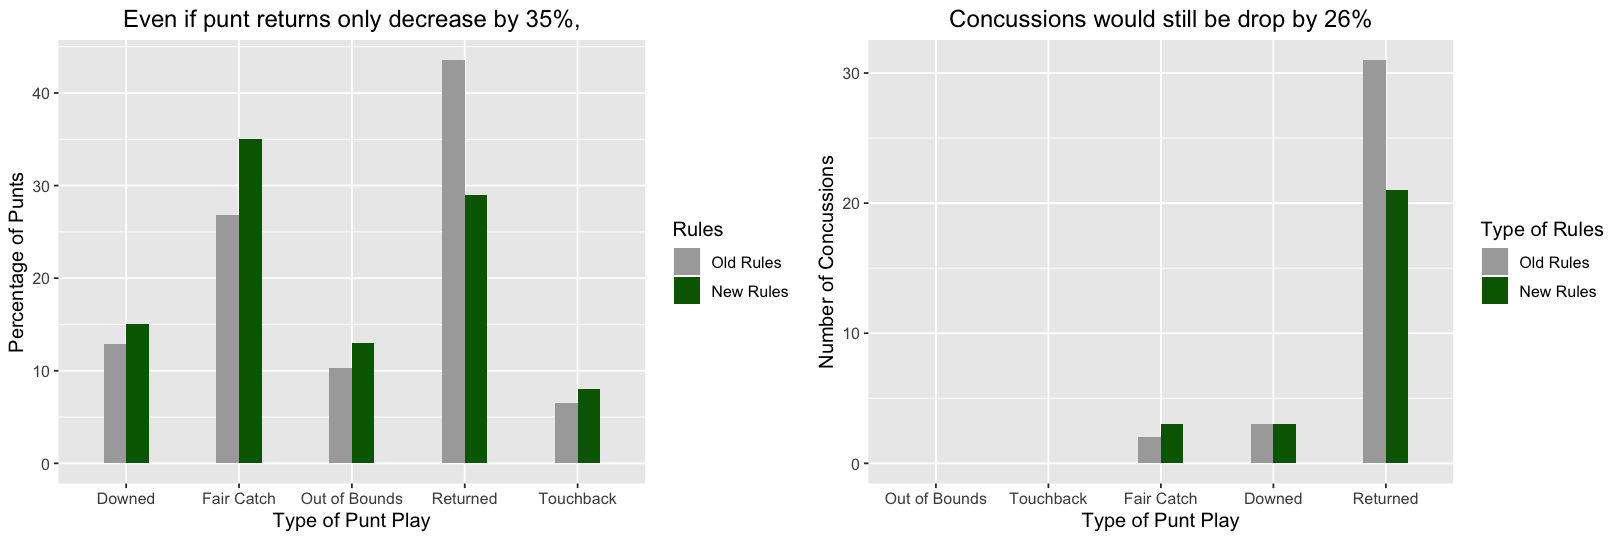

In [11]:
#35% scenario
newPercentPlay.touchback <- 8
newPercentPlay.out_of_bounds <- 13
newPercentPlay.downed_by <- 15
newPercentPlay.fair_catch <- 100-29-15-13-8
newPercentPlay.returned <- 29

newPercentPlay <- c(
  newPercentPlay.touchback,
  newPercentPlay.out_of_bounds,
  newPercentPlay.downed_by,
  newPercentPlay.fair_catch,
  newPercentPlay.returned)

concussionsDF["New Rules"] <- newPercentPlay

# Reduced concussions by 41%
reducedConcussionsBy <- getPercentDifferenceInConcussions(concussionsDF)

numConcussionsWithNewRules <- getNewConcussionsWithNewRules(newPercentPlay)
title <- "Concussions would still be drop by 26%"
g1 <- genBarchartComparingConcussionsWithNewRules(numConcussionsWithNewRules, title)

# Draw chart showing new breakdown of each type of punt play
percentOfPlays <- c(percentPlay, newPercentPlay)
rules <- c(replicate(5, "Old Rules"), replicate(5, "New Rules"))
rules <- factor(rules, levels = c("Old Rules", "New Rules"))
dfTmp <- data.frame(typeOfPlays, percentOfPlays, rules)

 g2 <- ggplot(dfTmp, aes(x=typeOfPlays, y=percentOfPlays, fill=rules)) + 
  geom_col(position="dodge", width=0.4) +
  scale_fill_manual(values=c("darkgrey","darkgreen")) +  
  theme(text = element_text(size=12),plot.title = element_text(hjust = 0.5)) +
  labs(y="Percentage of Punts", x="Type of Punt Play", fill="Rules",
      title="Even if punt returns only decrease by 35%,")

options(repr.plot.width=13.5, repr.plot.height=4.5)
grid.arrange(g2, g1, ncol=2)

# 4. Won't fans miss the excitement of punt returns?

While reducing the number of punt returns may at first seem to lead to less excitement, in the fact the opposite may be true. Long punt returns are exciting to watch, but unfortunately, they rarely happen. In fact, only **8%** of punt returns net more than 20 yards.

In [12]:
returns <- punts[punts$play_result=="Returned",]
round(nrow(returns[returns$Return_Yards>20,])/nrow(returns),2)

[1] 0.08

Even worse is that punt returns are much more likely to have a penalty than other types of punt plays. So not only are most punt returns anticlimactic, but they are leading to high rates of penalties which becomes fustrating for fans. Moreover, penalties lengthen the duration of the game, which is something that the NFL has been trying to address over the past few years.

Chance of Penalty on Returns: 20%
Chance of Penalty on Non-Returns: 8.3%

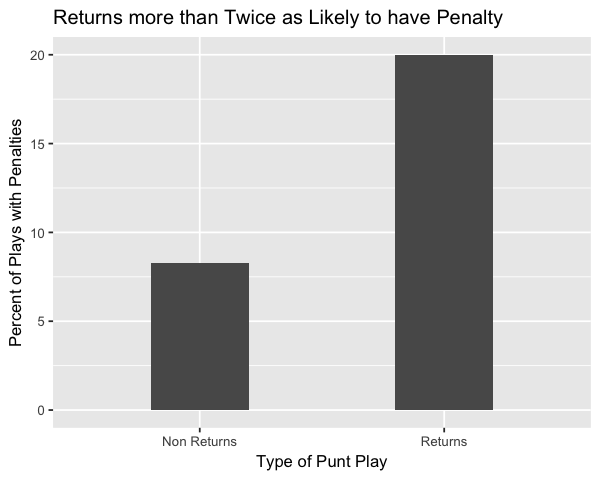

In [13]:
# % of returns with penalties
#returns <- punts[punts$play_result=="Returned",]
returnsWithPenalties <- round(sum(returns$Has_Penalty)/nrow(returns) * 100, 1)
cat(paste0("Chance of Penalty on Returns: ", returnsWithPenalties,"%"))

# % of non returns with penalties
nonReturns <- punts[punts$play_result!="Returned",]
nonReturnsWithPenalties <- round(sum(nonReturns$Has_Penalty)/nrow(nonReturns) * 100, 1)
cat(paste0("\nChance of Penalty on Non-Returns: ", nonReturnsWithPenalties,"%"))

#show returns with/without penalties
TypeOfReturn <- c("Non Returns", "Returns")
percentWithPenalties <- c(nonReturnsWithPenalties, returnsWithPenalties)
dfTmp <- data.frame(TypeOfReturn, percentWithPenalties)
options(repr.plot.width=5, repr.plot.height=4)
ggplot(dfTmp, aes(x=TypeOfReturn, y=percentWithPenalties)) + geom_col(width=0.4) + 
  ylab("Percent of Plays with Penalties") + xlab("Type of Punt Play") +
  theme(text = element_text(size=10)) +
  ggtitle("Returns more than Twice as Likely to have Penalty")  


What would replace these highly predicatble and heavily penalized punt returns? First of all, teams would go for it more on 4th down, since the expected net punt distance would reduced. This logic will be especially prevelant at around the 50 yard line. Coaches could decide to go for it more often, rather than to punt and concede a fair catch at the 10 yard line, which would start the opposing team's drive at the 15 yard line. More 4th down attempts add drama and excitement to the game, and would certainly be preferred over punts. 

Another stategic reaction to these rule changes that would be interesting is how punters would try to maximize punt distance despite the new fair catch bonus. Would they attempt to angle the punt so it lands out of bounds at its furthest distance? That is hard to execute without kicking it out of bounds too early and risk losing even more yards than the 5 yard fair catch bonus. Perhaps, punters would copy the technique of some college punters, where they attempt to "squib" the ball and have the ball skip down the field so as to avoid a fair catch or an easy recovery that would lead lead to a punt return. These strategies would be interesting to follow, and at a minimum they would be less penalized and much safer than punt returns.

# 5. Conclusion

### In closing, we project that the following rule changes will lower concussions by **41%**:

1. Fair catches should be incentivized with a 5 yard bonus (Add this rule under Rule 10, Section 2, Article 4)
2. All members of the punting team should be permitted to cross the line of scrimmage prior to the punt being kicked
      * To make this rule change, simply eliminate the "Ineligible Downfield Kick" penalty
      * This would revert back to the existing NFL rule before 1974, and would be similar to NCAA rules

We began this project with two goals. First, to decipher what factors were causing punt plays to lead to so many concussions. Second, what rule changes could mitigate the risk of concussions without sacrificing the integrity of the game. After all, it wouldn't be helpful to suggest a rule change that dramatically reduced concussions, but ruined the quality of the entertainment on the field. We have come up with two rule changes that would naturally push the incentives away from punt returns. As fans of the NFL, it was a rewarding challenge to design actionable rules that would help make the game substantially safer.